## Exploring COVID-19 Data through Modeling

We will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

We will demonstrate:
* Data cleaning and EDA using Pandas
* Modeling
* Visualization

In [1]:
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv



## Data Cleaning

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

In [2]:
cases = cases.fillna(0)
vaccinations = vaccinations.fillna(0)

Generate a valid FIPS code for the counties table.

In [3]:
str_state_num=counties[['STATE']].astype(str)
zero_extend_str_state = ['0'+x if len(x)==1 else x for x in str_state_num['STATE']]
str_county_num=counties[['COUNTY']].astype(str)
zero_extend_str_county = ['00'+x if len(x)==1 else '0'+x if len(x)==2 else x for x in str_county_num['COUNTY']]
str_state_num['STATE'] = zero_extend_str_state
str_county_num['COUNTY'] = zero_extend_str_county
FIPS =  str_state_num['STATE'] + str_county_num['COUNTY']
counties['FIPS'] = FIPS
counties['FIPS'] = counties['FIPS'].astype(str)

Merge the counties, cases, and mask_use tables on an appropriate primary key to generate county-wise data.

In [4]:
cases['FIPS'] = cases['FIPS'].astype(int)
cases['FIPS'] = cases['FIPS'].astype(str)
mask_use['COUNTYFP'] = mask_use['COUNTYFP'].astype(str)

zero_extend_cases = ['0'+x if len(x)==4 else x for x in cases['FIPS']]
zero_extend_mask_use = ['0'+x if len(x)==4 else x for x in mask_use['COUNTYFP']]
cases['FIPS'] = zero_extend_cases
mask_use['COUNTYFP'] = zero_extend_mask_use

county_data = counties.merge(cases, on='FIPS').merge(mask_use, left_on='FIPS',right_on='COUNTYFP')
county_data

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/9/21,9/10/21,9/11/21,9/12/21,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9145,9207,9246,9287,01001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34536,34726,34872,34950,01003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3243,3260,3282,3295,01005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3727,3752,3778,3795,01007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9048,9095,9161,9176,01009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6034,6111,6111,6111,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4587,4611,4611,4611,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3168,3204,3204,3204,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1111,1120,1120,1120,56043,0.204,0.155,0.069,0.285,0.287


## Guided Supervised Modeling

We will be creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

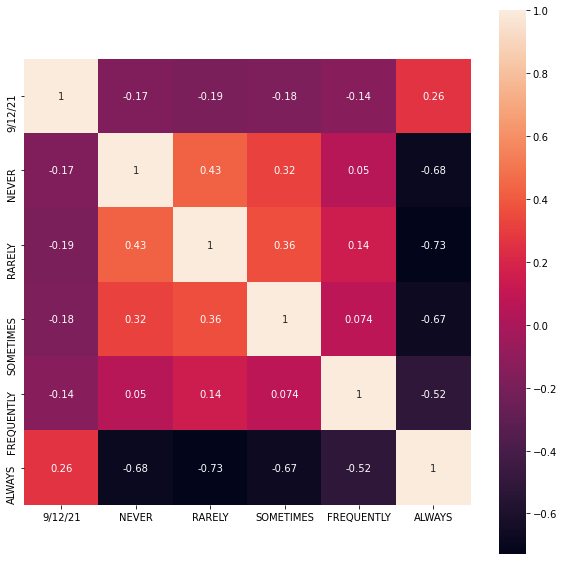

In [5]:
#Use a heatmap
plt.rcParams['figure.figsize'] = (10, 10)
plot1 = county_data[['9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
corr = plot1.corr()
sns.heatmap(corr, square=True, annot=True);

Training a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021.

In [6]:
X_p1 = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', '9/12/21']]
y_p1 = county_data['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_p1_train, X_p1_test = train_test_split(X_p1, test_size=0.33, random_state = 42)
y_p1_train, y_p1_test = np.array(X_p1_train['9/12/21']), np.array(X_p1_test['9/12/21'])

# Make sure to take out the '9/12/21' column
X_p1_train, X_p1_test = X_p1_train.iloc[:, :4], X_p1_test.iloc[:, :4]

model = LinearRegression()
model.fit(X_p1_train, y_p1_train)

train_rmse_cases = np.sqrt(np.mean((y_p1_train - model.predict(X_p1_train))**2))
test_rmse_cases = np.sqrt(np.mean((y_p1_test - model.predict(X_p1_test))**2))

train_rmse_cases, test_rmse_cases

(27836.041051400924, 62601.79076974604)

Instead of predicting the number of COVID-19 cases, redoing by predicting the number of cases per capita.

In [7]:
X_p2 = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_p2 = county_data['9/12/21']

per_capita_col = y_p2/county_data['POPESTIMATE2020']
X_p2['sept 12 cases per capita'] = per_capita_col

X_p2_train, X_p2_test = train_test_split(X_p2, test_size=0.33, random_state = 42)
y_p2_train, y_p2_test = X_p2_train['sept 12 cases per capita'], X_p2_test['sept 12 cases per capita']

# Make sure to take out the 'sept 12 cases per capita' column
X_p2_train, X_p2_test = X_p2_train.iloc[:, :4], X_p2_test.iloc[:, :4]

model2 = LinearRegression()
model2.fit(X_p2_train, y_p2_train)

train_rmse_cpc = np.sqrt(np.mean((y_p2_train - model2.predict(X_p2_train))**2))
test_rmse_cpc = np.sqrt(np.mean((y_p2_test - model2.predict(X_p2_test))**2))

train_rmse_cpc, test_rmse_cpc

(0.03541532334619034, 0.038164946474777875)

Visualizing the model outputs from before by plotting the predictions $\hat{y}$ versus the observations $y$.

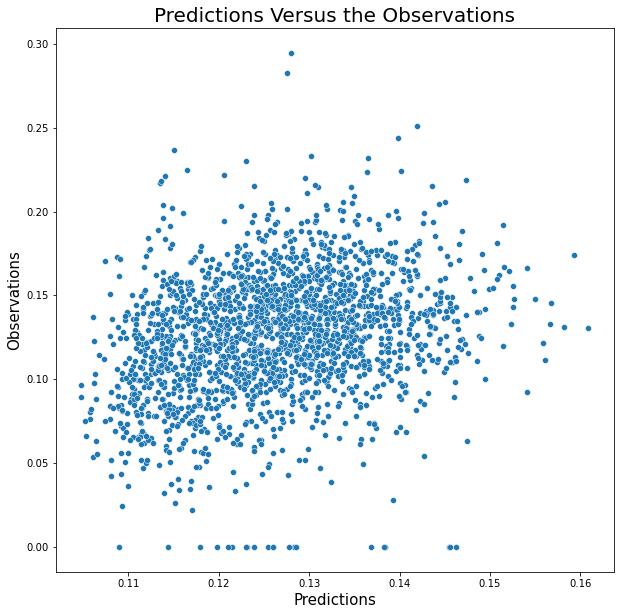

In [8]:
#Removing some outliers
plotp3DataFrame = pd.DataFrame({'pred':model2.predict(X_p2_train), 'obs':y_p2_train})
plotp3DataFrame = plotp3DataFrame[plotp3DataFrame['obs']<0.3]

plotp3X = plotp3DataFrame['pred']
plotp3Y = plotp3DataFrame['obs']
plt.rcParams['figure.figsize'] = (10, 10)
plt.title('Predictions Versus the Observations', fontsize = 20)
plt.xlabel('Predictions', fontsize = 15)
plt.ylabel('Observations', fontsize = 15)
sns.scatterplot(x=plotp3X, y=plotp3Y);

# This plot indicates there is some correlation between observations and predictions.

## Part 2

The hypothesis we will be testing now is whether the majority of variation in unemployment numbers across counties can be explained by the number of cases across counties as well as masking rates across counties. This hypothesis can be confirmed if the R^2 value for our model that predicts unemployment levels from case and masking rates is above 0.6.

In [9]:
# uploading unemployment data
# data can be found under 'county data' in: https://www.bls.gov/lau/

unemployment_rate = pd.read_csv('data/copy-of-laucntycur14.csv', dtype = {'state code':'str', 'county code':'str'}) 
unemployment_rate['FIPS'] = unemployment_rate['state code'] + unemployment_rate['county code']
unemployment_rate = unemployment_rate[['County Name/State Abbreviation', 'Period', 'Force', 'Employed', 'Unemployed', '(%)', 'FIPS']]

In [10]:
# Cross Validation Functions

from sklearn.model_selection import KFold
def rmse(actual_y, predicted_y):
    return np.sqrt(np.mean((actual_y - predicted_y)**2))
def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx,:], X_train.iloc[valid_idx,:]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        model.fit(split_X_train, split_Y_train)
        error = rmse(model.predict(split_X_valid), split_Y_valid)
        validation_errors.append(error)
    return np.mean(validation_errors)

In [11]:
unemployment_data = unemployment_rate.iloc[:45066,:]
unemployment_data['(%)'] = unemployment_data['(%)'].astype(float)/100
unemployment_rates_data = pd.pivot(data=unemployment_data, index='FIPS', columns='Period', values='(%)')
unemployment_rates_data = unemployment_rates_data[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21', 'Sep-21']]
unemployment_rates_data = unemployment_rates_data.reset_index()

model_data = unemployment_rates_data.merge(county_data, on = 'FIPS')
model_data = model_data[['FIPS', 'POPESTIMATE2020','Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21', '9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
model_data

# In this cell I made it possible to join our imported data on unemployment with our county_data.
# I made this possible by pivoting the data so that FIPS would just be the index, the columns would be the months, and the unemployment rates would make up the values.

,FIPS,POPESTIMATE2020,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,...,4/30/21,5/31/21,6/30/21,7/31/21,8/31/21,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,01001,56145,0.055,0.034,0.031,0.029,0.033,0.031,0.029,0.024,...,6904,7142,7257,7537,8758,0.053,0.074,0.134,0.295,0.444
1,01003,229287,0.059,0.039,0.034,0.031,0.035,0.033,0.030,0.025,...,20941,21620,22027,25207,33090,0.083,0.059,0.098,0.323,0.436
2,01005,24589,0.101,0.069,0.060,0.057,0.067,0.062,0.056,0.048,...,2300,2334,2346,2506,3060,0.067,0.121,0.120,0.201,0.491
3,01007,22136,0.070,0.045,0.041,0.038,0.041,0.036,0.034,0.030,...,2594,2664,2693,2897,3479,0.020,0.034,0.096,0.278,0.572
4,01009,57879,0.043,0.026,0.024,0.022,0.024,0.022,0.024,0.022,...,6613,6864,6987,7352,8595,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,42673,0.072,0.054,0.059,0.068,0.078,0.077,0.070,0.069,...,4230,4496,4771,4998,5617,0.061,0.295,0.230,0.146,0.268
3136,56039,23497,0.037,0.037,0.062,0.042,0.043,0.044,0.042,0.071,...,3732,3784,3801,3897,4427,0.095,0.157,0.160,0.247,0.340
3137,56041,20215,0.061,0.047,0.050,0.055,0.065,0.072,0.065,0.064,...,2183,2266,2320,2414,2971,0.098,0.278,0.154,0.207,0.264
3138,56043,7760,0.045,0.033,0.044,0.046,0.056,0.055,0.052,0.051,...,903,922,926,945,1037,0.204,0.155,0.069,0.285,0.287


In [12]:
trial = model_data[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21']].T
trial2 = model_data[['9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21']].T

percentages6a = []
for col in trial.columns:
    percentages6a+=list(trial[col])
    
cases6a = []
for col in trial2.columns:
    cases6a+=list(trial2[col])

FIPS6a = []
NEVER6a = []
RARELY6a = []
SOMETIMES6a = []
FREQUENTLY6a = []
ALWAYS6a = []
POPESTIMATE20206a = []
for i in range(len(model_data['FIPS'])):
    
    for j in range(12):
        FIPS6a.append(model_data['FIPS'][i])
        NEVER6a.append(model_data['NEVER'][i])
        RARELY6a.append(model_data['RARELY'][i])
        SOMETIMES6a.append(model_data['SOMETIMES'][i])
        FREQUENTLY6a.append(model_data['FREQUENTLY'][i])
        ALWAYS6a.append(model_data['ALWAYS'][i])
        POPESTIMATE20206a.append(model_data['POPESTIMATE2020'][i])

labor = pd.DataFrame({'FIPS': FIPS6a, 'NEVER':NEVER6a, 'RARELY':RARELY6a, 'SOMETIMES':SOMETIMES6a, 'FREQUENTLY':FREQUENTLY6a, 'ALWAYS':ALWAYS6a, 'Percentage':percentages6a, 'Cases':cases6a, 'POPESTIMATE2020':POPESTIMATE20206a})
labor


# In order to create the model I needed to combine the values (unemployment rates)for each month into one row
# AS well as the number of cases for each month. Finally I just repeated FIPS, NEVER, RARELY, SOMETIMES, FREQUENTLY, ALWAYS, and POPESTIMATE2020 12 times for each value since there are 12 months we are using.

,FIPS,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Percentage,Cases,POPESTIMATE2020
0,01001,0.053,0.074,0.134,0.295,0.444,0.055,1792,56145
1,01001,0.053,0.074,0.134,0.295,0.444,0.034,2168,56145
2,01001,0.053,0.074,0.134,0.295,0.444,0.031,2780,56145
3,01001,0.053,0.074,0.134,0.295,0.444,0.029,4190,56145
4,01001,0.053,0.074,0.134,0.295,0.444,0.033,5669,56145
...,...,...,...,...,...,...,...,...,...
37675,56045,0.142,0.129,0.148,0.207,0.374,0.039,650,6743
37676,56045,0.142,0.129,0.148,0.207,0.374,0.040,654,6743
37677,56045,0.142,0.129,0.148,0.207,0.374,0.038,657,6743
37678,56045,0.142,0.129,0.148,0.207,0.374,0.031,681,6743


In [13]:
X=labor[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Cases']]
X['Cases'] = X['Cases']/labor['POPESTIMATE2020']
y=labor['Percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

our_model6a = LinearRegression()
our_model6a.fit(X_train, y_train)
our_model6a.predict(X_train)

error = compute_CV_error(our_model6a, X_train, y_train)
corr = our_model6a.score(X_train, y_train)
print("Our Training Accuracy: ", corr)
print("Our Cross Validation Error: ", error)


# In this cell we created our first model using the unemployment rate as what we are trying to predict. 
# For the parameters I used the mask rates and the number of cases per capita. 

Our Training Accuracy:  0.1553574813243972
Our Cross Validation Error:  0.019587584079798187


Tried to use the percentage of unemployment for each county and date as our target values. Then used the 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS' and 'Cases' per capita parameters from our dataframe for the matrix of features. However, from this model it seems that our accuracy is very low and it could be our hypothesis was wrong.

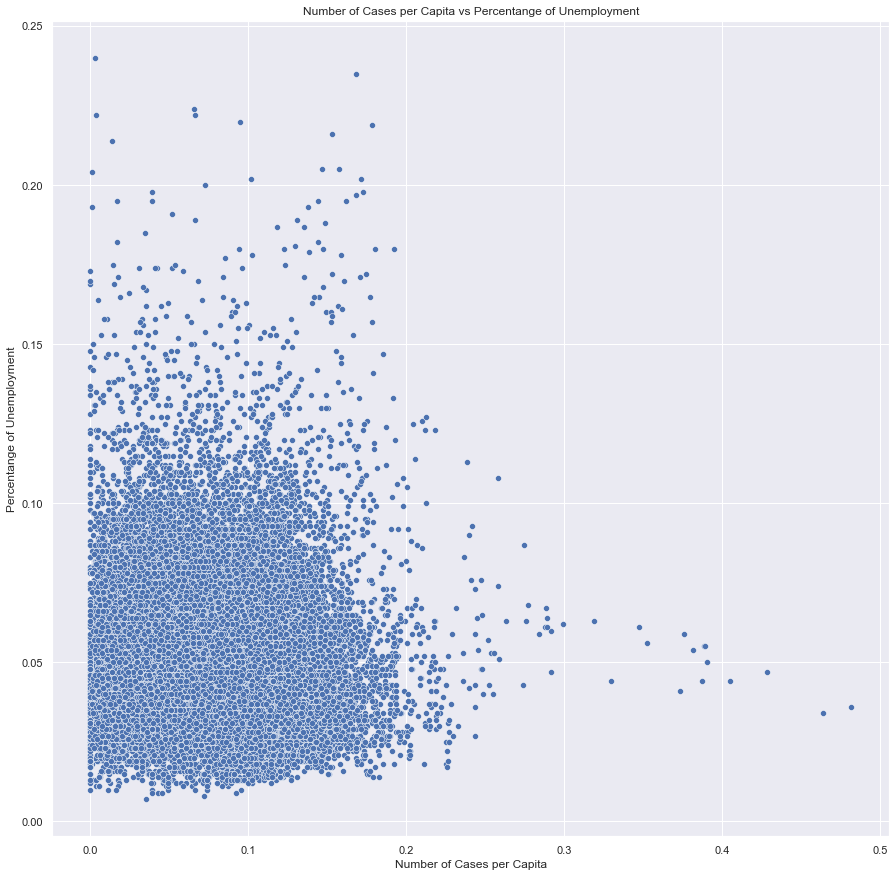

In [14]:
sns.set(rc = {'figure.figsize':(15,15)})
plt.xlabel('Number of Cases per Capita')
plt.ylabel('Percentange of Unemployment')
plt.title('Number of Cases per Capita vs Percentange of Unemployment')
sns.scatterplot(x=X['Cases'], y=y);


# As seen in the graph, the correlation between the Number of Cases and the Unemployment rate is very low

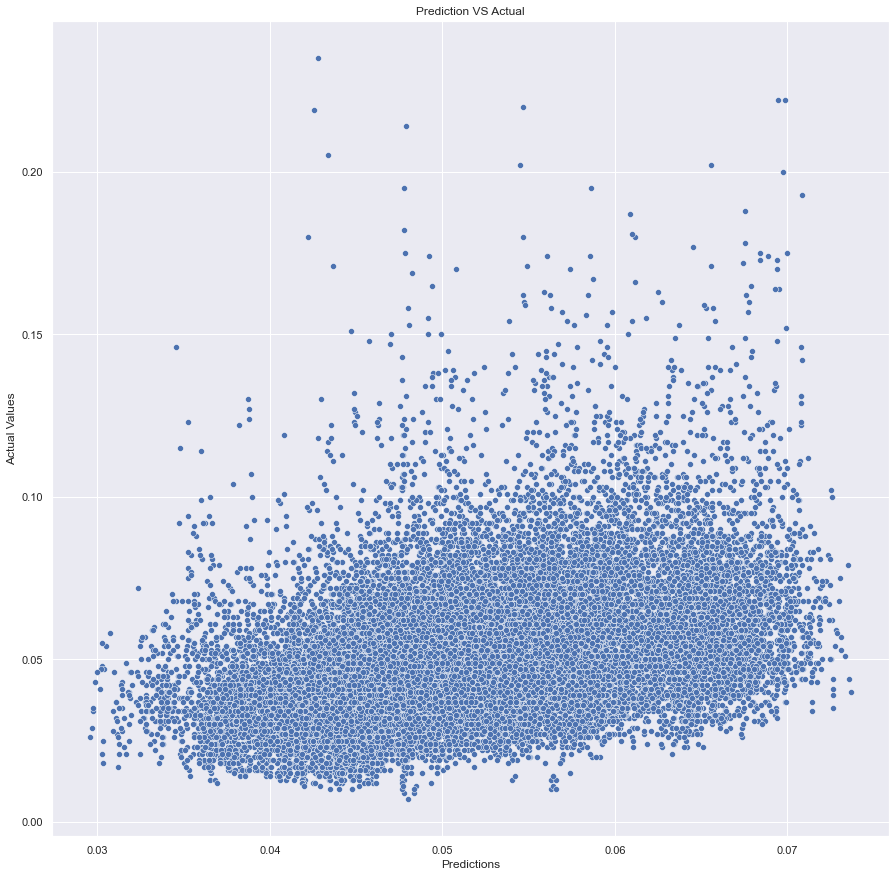

In [15]:
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.title('Prediction VS Actual')
sns.scatterplot(x=our_model6a.predict(X_train), y=y_train);

## Lets improve our model

In [16]:
unemployment_data2 = unemployment_rate.iloc[:45066,:]
unemployment_data2['Unemployed'] = unemployment_data2['Unemployed'].str.replace(',', '').astype(int)
unemployment_rates_data2 = pd.pivot(data=unemployment_data2, index='FIPS', columns='Period', values='Unemployed')
unemployment_rates_data2 = unemployment_rates_data2[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21', 'Sep-21']]
unemployment_rates_data2 = unemployment_rates_data2.reset_index()

model_data2 = unemployment_rates_data2.merge(county_data, on = 'FIPS')
model_data2 = model_data2[['FIPS', 'POPESTIMATE2020','Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21', '9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]


# Same thing as before where I merge the unemployment data with county_data, except now for the values we are using the number of people unemployed rather than the unemployment rate.
# I did this for a good reason as explain below

In [17]:
trial3 = model_data2[['Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21']].T
trial4 = model_data2[['9/30/20', '10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21', '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21']].T

percentages6a2 = []
for col in trial3.columns:
    percentages6a2+=list(trial3[col])
    
cases6a2 = []
for col in trial4.columns:
    cases6a2+=list(trial4[col])

FIPS6a2 = []
NEVER6a2 = []
RARELY6a2 = []
SOMETIMES6a2 = []
FREQUENTLY6a2 = []
ALWAYS6a2 = []
POPESTIMATE20206a2 = []
for i in range(len(model_data2['FIPS'])):
    
    for j in range(12):
        FIPS6a2.append(model_data2['FIPS'][i])
        NEVER6a2.append(model_data2['NEVER'][i])
        RARELY6a2.append(model_data2['RARELY'][i])
        SOMETIMES6a2.append(model_data2['SOMETIMES'][i])
        FREQUENTLY6a2.append(model_data2['FREQUENTLY'][i])
        ALWAYS6a2.append(model_data2['ALWAYS'][i])
        POPESTIMATE20206a2.append(model_data2['POPESTIMATE2020'][i])

labor2 = pd.DataFrame({'FIPS': FIPS6a2, 'NEVER':NEVER6a2, 'RARELY':RARELY6a2, 'SOMETIMES':SOMETIMES6a2, 'FREQUENTLY':FREQUENTLY6a2, 'ALWAYS':ALWAYS6a2, 'Unemployed':percentages6a2, 'Cases':cases6a2, 'POPESTIMATE2020':POPESTIMATE20206a2})


# Same thing as before where I prepare the data to be used for the model by making only 9 larger columns (since we are combining by months). 1 for what we are trying to predict and 8 for the parameter.

In [18]:
X2=labor2[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Cases']]
X2['Cases Per Capita'] = X2['Cases'] / labor2['POPESTIMATE2020']
y2=labor2['Unemployed'] / labor2['POPESTIMATE2020']
X2 = X2[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Cases Per Capita']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)

our_model6a2 = LinearRegression()
our_model6a2.fit(X_train2, y_train2)
our_model6a2.predict(X_train2)

error2 = compute_CV_error(our_model6a2, X_train2, y_train2)
corr2 = our_model6a2.score(X_train2, y_train2)
print("Our Training Accuracy: ", corr2)
print("Our Cross Validation Error: ", error2)


# Previously I used the unemployment rate as what I tried to predict, however I saw that the unemployment rate consisted of number of people unemplyed and number of people in the workforce. 
# Thus, the number of people in the workforce was another factor I hadn't accounted for since it also changed through time.
# So instead this time I decided to use the number of of unemployed people as it was. 
# Then I divided both the number of people unemployed and the number of cases by the county's total population.

Our Training Accuracy:  0.19758252040209312
Our Cross Validation Error:  0.007640439371202426


To try to improve the model, I decided to use the number of people unemployed in a county rather than the proportion of unemployed/work force. Having this data we decided to take the number of cases and number of unemployed and divide them by the total population. I kept everything else the same, however, the accuracy didn't increase as much as I had originally thought.

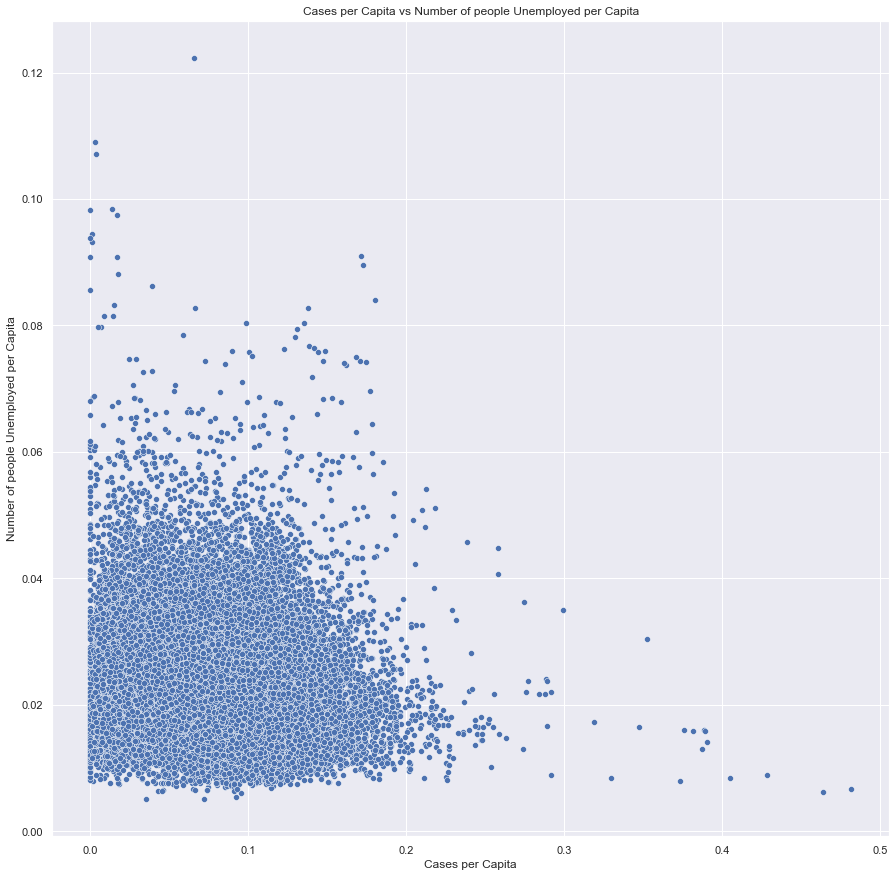

In [19]:
plt.xlabel('Cases per Capita')
plt.ylabel('Number of people Unemployed per Capita')
plt.title('Cases per Capita vs Number of people Unemployed per Capita')
sns.scatterplot(x=X2['Cases Per Capita'], y=y2);

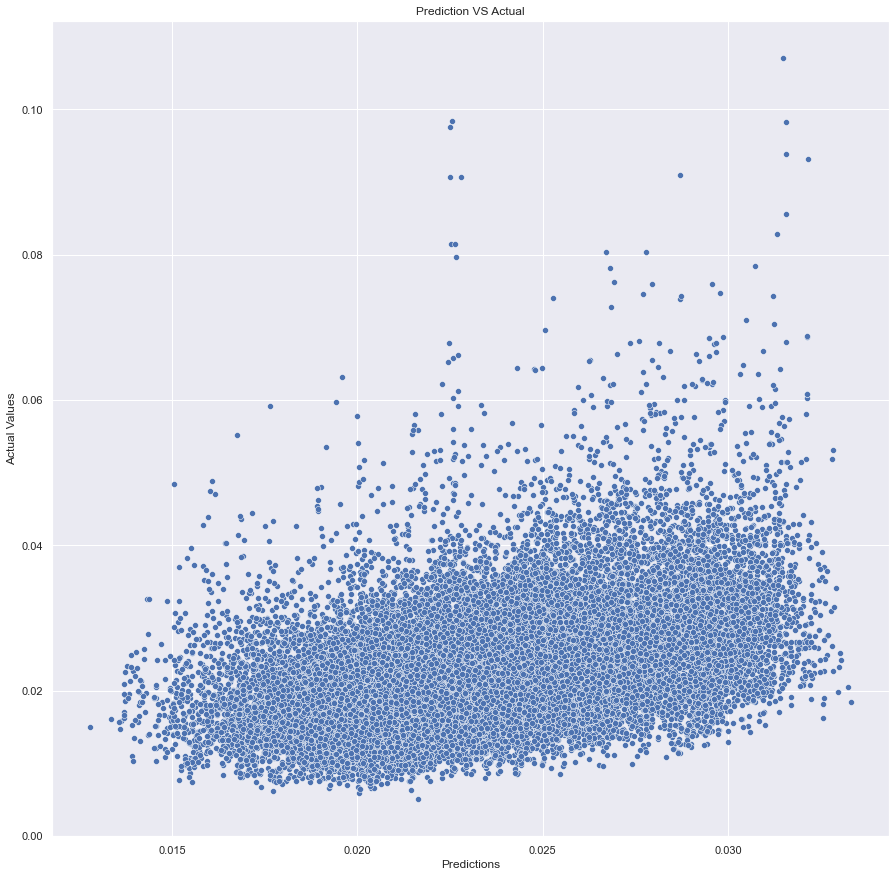

In [20]:
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.title('Prediction VS Actual')
sns.scatterplot(x=our_model6a2.predict(X_train2), y=y_train2);

## Improving Even Further!

In [21]:
X3=labor2[['Cases', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y3=labor2['Unemployed']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.33, random_state=42)

our_model6a3 = LinearRegression()
our_model6a3.fit(X_train3, y_train3)
our_model6a3.predict(X_train3)

error3 = compute_CV_error(our_model6a3, X_train3, y_train3)
corr3 = our_model6a3.score(X_train3, y_train3)
print("Our Training Accuracy: ", corr3)
print("Our Cross Validation Error: ", error3)

Our Training Accuracy:  0.690368773561041
Our Cross Validation Error:  7535.1802799108045


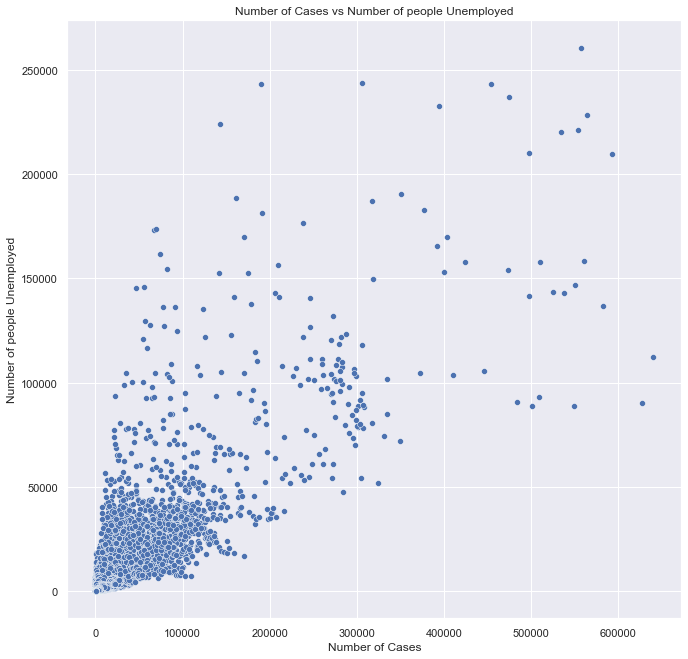

In [22]:
# Remove outliers
final_plotX = labor2[labor2['Unemployed']< 300000]['Cases']
final_ploty = labor2[labor2['Unemployed']< 300000]['Unemployed']

plt.figure(figsize=(11, 11))
sns.scatterplot(x=final_plotX, y=final_ploty)
plt.xlabel('Number of Cases')
plt.ylabel('Number of people Unemployed')
plt.title('Number of Cases vs Number of people Unemployed');

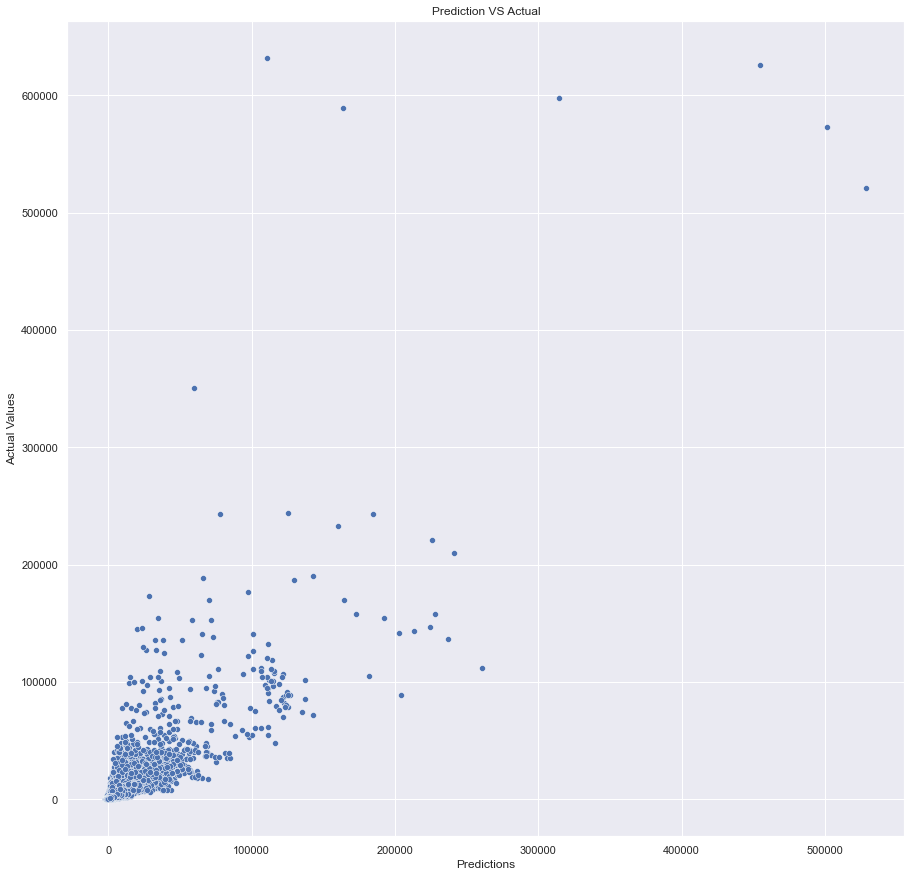

In [23]:
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.title('Prediction VS Actual')
sns.scatterplot(x=our_model6a3.predict(X_train3), y=y_train3);

Finally instead of to divide both the number of cases and the nuber of unemployed people by the total population in that county, I decided to just leave the number of cases and the nuber of unemployed people as they were and try to predict the nuber of unemployed people by the number of cases and the parameters for mask usage. As seen throught all graphs, the correlation between number of cases and number of unemployed seems much higher than the rest.

In [24]:
# Testing the final model on the test data

our_model6a3.predict(X_test3)

error3 = compute_CV_error(our_model6a3, X_test3, y_test3)
corr3 = our_model6a3.score(X_test3, y_test3)
print("Our Testing Accuracy: ", corr3)
print("Our Testing Cross Validation Error: ", error3)

Our Testing Accuracy:  0.7916915833144682
Our Testing Cross Validation Error:  7145.793624921139


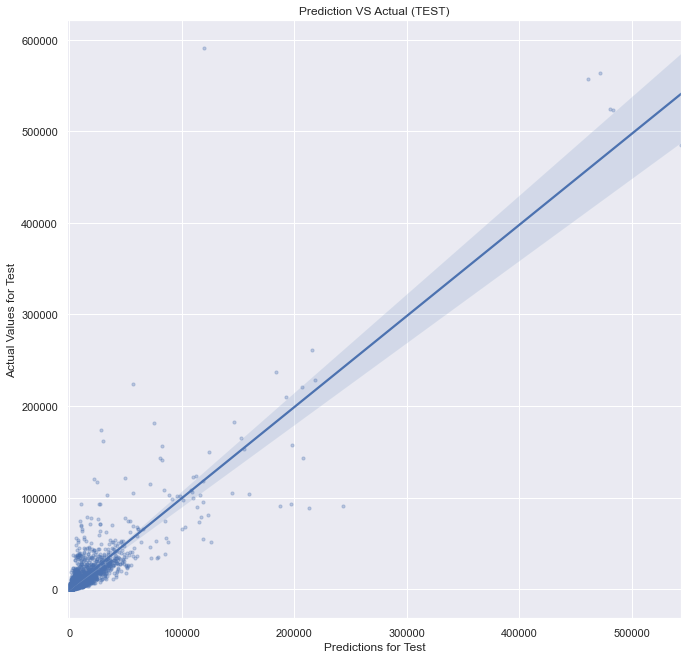

In [25]:
testDataFrame = pd.DataFrame({'actual':y_test3, 'prediction':our_model6a3.predict(X_test3)})
plt.figure(figsize=(11, 11))

# text
# Plotting the final model with test data.
# Below I removed some outliers to zoom in 

sns.regplot(data = testDataFrame, x='prediction', y='actual', scatter_kws={'s':10, "alpha":0.3})
plt.xlabel('Predictions for Test')
plt.ylabel('Actual Values for Test')
plt.title('Prediction VS Actual (TEST)');

In [26]:
list_of_coef = list(our_model6a3.coef_)
list_of_coef
# Equation f(x): predicting function
# f(x) = 0.3856157624872213*CASES + 163129.5268858097*NEVER + 162064.19088911277*RARELY + 160995.8475563524*SOMETIMES + 160194.6650264655*FREQUENTLY + 166360.547540274*ALWAYS

[0.3856157624872213,
 163129.5268858097,
 162064.19088911277,
 160995.8475563524,
 160194.6650264655,
 166360.547540274]

**CASES**: referes to the number of cases in a county 

**Never**: referes to the percentage of people who never use masks in a county

**RARELY**: referes to the percentage of people who RARELY use masks in a county

**SOMETIMES**: referes to the percentage of people who SOMETIMES use masks in a county

**FREQUENTLY**: referes to the percentage of people who FREQUENTLY use masks in a county

**ALWAYS**: referes to the percentage of people who ALWAYS use masks in a county

**f(x)**: referes to the number of people unemployed in a county

In evaluating the model, it's calculated that the R^2 value for our predicted unemployment numbers in the test data vs. the actual unemployment numbers in the test data was 0.792. This shows that unemployment numbers across counties are highly correlated with case numbers and masking rates across counties. It is appropriate to look at the R^2 value when evaluating our model because we want to understand how close the data is to our fitted regression line.